In [1]:
import numpy as np
import pandas as pd
import warnings
from scipy.stats import chi2_contingency
from scipy import stats
from matplotlib import pyplot as plt
import json
import yapf.yapflib.yapf_api
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")

1 Read the dataset 
========

In [2]:
data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt", sep=",")

In [3]:
# change field 38 to 3 groups
condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)

In [4]:
data["max"] = np.min(
    data[["FIELD_6", "FIELD_7"]], axis=1
)  # combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)

data = data.drop(columns=["FIELD_6", "FIELD_7", "B_DAY"])
print(data.shape)

(535169, 405)


In [5]:
# add Class to the dataset
_class = []
for i in range(data.shape[0]):
    if (data.S000501[i] >= 140) | (data.S000502[i] >= 90):
        _class.append(2)
    elif (data.S000501[i] < 120) & (data.S000502[i] < 80):
        _class.append(0)
    else:
        _class.append(1)
data["CLASS"] = _class

In [6]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia

data = data[data.FIELD_13 != 1]  
data = data[data.FIELD_20 != 1]  

print(data.shape)

(465879, 406)


In [7]:
# rename columns
data.rename(
    columns={
        "L104600": "HBA1C",
        "L103000": "Triglycerides",
        "L100800": "fasting glucose",
        "S000300": "BMI",
        "S000501": "SBP",
        "S000502": "DBP",
        "L101700": "r-GTP gamma",
        "L103300": "Cardiac risk factor",
        "L190400": "Hemoglobin",
        "L190500": "HCT",
        "L100700": "Uric Acid",
        "L101300": "SGPT",
        "L190300": "RBC",
        "L102900": "total cholesterol",
        "L103100": "HDL-Cholesterol",
    },
    inplace=True,
)

In [8]:
# split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith("FIELD")])
categorical_cols = list(data.columns[data.columns.str.startswith("FIELD")])
categorical_cols.append("CLASS")
numerical_cols.remove("SEX")
categorical_cols.append("SEX")

In [9]:
print(data.shape)
print(data.groupby(by='CLASS').size())

mydata=data.copy()
class2 = mydata[mydata.CLASS == 2]
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

data = pd.concat([class2, class1.sample(class2.shape[0],random_state=42), 
                  class0.sample(class2.shape[0],random_state=42)])

print(data.shape)

(465879, 406)
CLASS
0    239294
1    208467
2     18118
dtype: int64
(54354, 406)


2 Feature Selection
===========

2.1 Calculate correlation Value - for numerical values
========

2.1.1 Pearson Correlation
======

In [10]:
corr = data[numerical_cols].corr()  # compute the correlation value
corr = corr.CLASS  # select the correlation values of the Class

# convert correlation values to dataframe
corrvalPD = pd.DataFrame()
corrvalPD["Col"] = corr.index
corrvalPD["val"] = abs(corr.values)

corrvalPD = corrvalPD.sort_values(by="val", ascending=False)
corrvalPD.head()

,Col,val
275,CLASS,1.0
262,S004421,1.0
109,L202700,1.0
139,L403300,1.0
44,L105700,1.0


In [11]:
# get count of none NA values of each feature set
mydataset = data.copy()[numerical_cols]
colCount = []
for i in mydataset.columns:
    colCount.append([i, mydataset[i].dropna().shape[0]])

colCountPD = pd.DataFrame(colCount, columns=["Col", "Count"])
colCountPD.head()

,Col,Count
0,Unnamed: 0,54354
1,COMPARE,54354
2,AGE,54354
3,L100100,51902
4,L100200,51948


In [12]:
# merge the correlation value and the total count of the feature
mergedColCorrCount = pd.merge(
    corrvalPD, colCountPD, how="inner", left_on="Col", right_on="Col"
)
mergedColCorrCount = mergedColCorrCount[mergedColCorrCount.Count > 50000]
mergedColCorrCount = mergedColCorrCount.sort_values(by="val", ascending=False)
mergedColCorrCount.head(10)

,Col,val,Count
0,CLASS,1.000000,54354
13,SBP,0.860218,54321
14,DBP,0.825214,54321
21,BMI,0.433475,54221
31,Hemoglobin,0.325775,54291
32,RBC,0.322953,54191
35,HCT,0.315204,54170
38,Uric Acid,0.291779,52041
39,fasting glucose,0.285393,54291
40,Triglycerides,0.281977,54184


In [13]:
# select top 20 correlated features
print(list(mergedColCorrCount.head(16).Col))

['CLASS', 'SBP', 'DBP', 'BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'r-GTP gamma', 'AGE', 'L101600', 'total cholesterol', 'L100500', 'HDL-Cholesterol']


2.1.2 Anova test
=======

In [14]:
# another option for feature selection of numerical values

mydataset = data.copy()[numerical_cols]  # filter only numrical columns
colslist = mydataset.columns
DiabeticColVals = mydataset.CLASS

cor = []
pval = []
count = []

# for each column compute f and p values
for i in range(len(colslist)):

    temp = pd.DataFrame([])
    temp["a"] = DiabeticColVals
    temp["b"] = mydataset[colslist[i]]
    temp = temp.dropna()

    count.append(temp.shape[0])
    tempcor = temp.corr()

    if tempcor.shape[0] > 1:
        F, p = stats.f_oneway(
            temp[temp["a"] == 0].b, temp[temp["a"] == 1].b, temp[temp["a"] == 2].b
        )
        cor.append(F)
        pval.append(p)
    else:
        cor.append(0)
        pval.append(0)

In [15]:
FvalPvalCorr = pd.DataFrame()
FvalPvalCorr["Cols"] = colslist
FvalPvalCorr["F"] = cor
FvalPvalCorr["P"] = pval
FvalPvalCorr["Count"] = count
FvalPvalCorr = FvalPvalCorr.sort_values(by="F", ascending=False)

In [87]:
# select top 20 features
print(list(FvalPvalCorr[FvalPvalCorr.Count > 40000].Cols)[:25])
FvalPvalCorr[FvalPvalCorr.Count > 40000].head(30)

['CLASS', 'SBP', 'DBP', 'BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'Cardiac risk factor', 'r-GTP gamma', 'AGE', 'L101600', 'S010101', 'total cholesterol', 'S010102', 'L100500', 'HDL-Cholesterol', 'S000100', 'SGPT', 'L101400', 'L190000', 'L190800', 'L504700']


,Cols,F,P,Count
275,CLASS,inf,0.000000e+00,54354
212,SBP,7.860757e+04,0.000000e+00,54321
213,DBP,5.797356e+04,0.000000e+00,54321
210,BMI,6.373788e+03,0.000000e+00,54221
91,Hemoglobin,3.546321e+03,0.000000e+00,54291
90,RBC,3.457629e+03,0.000000e+00,54191
92,HCT,3.311376e+03,0.000000e+00,54170
8,Uric Acid,2.603384e+03,0.000000e+00,52041
9,fasting glucose,2.409381e+03,0.000000e+00,54291
24,Triglycerides,2.341443e+03,0.000000e+00,54184


2.2 Correlation for categorical values
============

2.2.1 chi2 method
=====

In [17]:
# rename commen field names
categorical_cols[categorical_cols.index("FIELD_33")] = "_4_1_Smoking"
categorical_cols[categorical_cols.index("FIELD_38")] = "Drinking_5_1_days"
categorical_cols[
    categorical_cols.index("FIELD_40")
] = "_6_1_of_physical_activity_high_strength"
categorical_cols[categorical_cols.index("FIELD_31")] = "Family_history"
categorical_cols[
    categorical_cols.index("FIELD_41")
] = "_6_2_of_physical_activity_moderate"
categorical_cols[categorical_cols.index("FIELD_27")] = "_2_family_history_stroke"
categorical_cols[categorical_cols.index("FIELD_21")] = "_1_medication_heart_disease"
categorical_cols[categorical_cols.index("FIELD_14")] = "Whether_one_diagnosis_disease"
categorical_cols[categorical_cols.index("FIELD_32")] = "_3B_hepatitis"
categorical_cols[
    categorical_cols.index("FIELD_42")
] = "_6_3_of_physical_activity_walking"
categorical_cols[categorical_cols.index("FIELD_4")] = "blood_type"
categorical_cols[categorical_cols.index("FIELD_29")] = "_2_family_history_hypertension"
categorical_cols[categorical_cols.index("FIELD_3")] = "Blood_factor_RH_factor"
categorical_cols[categorical_cols.index("FIELD_19")] = "_1_drug_therapy_stroke"

In [18]:
mydata = data.rename(
    columns={
        "FIELD_33": "_4_1_Smoking",
        "FIELD_38": "Drinking_5_1_days",
        "FIELD_40": "_6_1_of_physical_activity_high_strength",
        "FIELD_31": "Family_history",
        "FIELD_41": "_6_2_of_physical_activity_moderate",
        "FIELD_27": "_2_family_history_stroke",
        "FIELD_21": "_1_medication_heart_disease",
        "FIELD_14": "Whether_one_diagnosis_disease",
        "FIELD_32": "_3B_hepatitis",
        "FIELD_42": "_6_3_of_physical_activity_walking",
        "FIELD_4": "blood_type",
        "FIELD_29": "_2_family_history_hypertension",
        "FIELD_3": "Blood_factor_RH_factor",
        "FIELD_19": "_1_drug_therapy_stroke",
    },
    inplace=True,
)


# mydata=data[categorical_cols] # filter only categorical columns

In [19]:
# filter only categorical columns
mydata = data[categorical_cols]
# remove columns with string values as data type
mydata = mydata.drop(
    columns=[
        "FIELD_1",
        "FIELD_2",
        "FIELD_8",
        "FIELD_10",
        "FIELD_11",
        "FIELD_12",
        "FIELD_39",
        "FIELD_88",
        "FIELD_89",
        "FIELD_109",
        "FIELD_110",
        "FIELD_111",
        "FIELD_70",
        "FIELD_82",
        "FIELD_85",
        "FIELD_91",
        "FIELD_103",
        "FIELD_106",
    ]
)

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_38_C,CLASS,SEX
3,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0
4,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0
50,1,3,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,1.0
82,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0
83,1,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0


In [20]:
# Data clean up
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "`"]
    .dropna()
    .index
)
mydata = mydata.drop(
    mydata[["Blood_factor_RH_factor"]][mydata[["Blood_factor_RH_factor"]] == "G"]
    .dropna()
    .index
)

mydata = mydata.drop(
    mydata[["blood_type"]][mydata[["blood_type"]] == "."].dropna().index
)
mydata = mydata.drop(mydata[mydata.FIELD_5 == "."].index)


mydata = mydata.drop(mydata[mydata.FIELD_35 == "?"].index)
mydata = mydata.drop(mydata[mydata.FIELD_35 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_36 == "."].index)
mydata = mydata.drop(mydata[mydata.FIELD_37 == "\\"].index)
mydata.head()

# mydata=mydata.drop(mydata[mydata.FIELD_39 == '7+' ].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '5~7'].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '3-4'].index)


mydata = mydata.drop(mydata[mydata.FIELD_95 == "."].index)
mydata.head()

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_38_C,CLASS,SEX
3,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0
4,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0
50,1,3,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,1.0
82,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0
83,1,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,0.0


In [21]:
AllTables = []

# prepare the table indicating the number of entries per class and per each column group
for j in range(len(mydata.columns)):

    columnName = mydata.columns[j]
    print(j, columnName)

    temp = mydata[columnName].dropna().astype(float).unique()
    mytempdata = mydata[[columnName, "CLASS"]].dropna()
    mytempdata[columnName] = mytempdata[columnName].astype(float)
    temptable = []

    sumval = 0

    for i in range(temp.shape[0]):

        temp_i_val = str(temp[i])
        class0_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 0"
        ).shape[0]
        class1_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 1"
        ).shape[0]
        class2_count = mytempdata.query(
            columnName + " == " + (temp_i_val) + " & CLASS == 2"
        ).shape[0]

        sumval = sumval + (class0_count + class1_count + class2_count)

        temptable.append([class0_count, class1_count, class2_count])

    #     print(sumval,mytempdata.shape[0], mytempdata.shape[0] == sumval)

    if len(temptable) > 1:
        AllTables.append([temptable, columnName, mytempdata.shape[0]])

0 Blood_factor_RH_factor
1 blood_type
2 FIELD_5
3 FIELD_9
4 FIELD_13
5 Whether_one_diagnosis_disease
6 FIELD_15
7 FIELD_16
8 FIELD_17
9 FIELD_18
10 _1_drug_therapy_stroke
11 FIELD_20
12 _1_medication_heart_disease
13 FIELD_22
14 FIELD_23
15 FIELD_24
16 FIELD_25
17 FIELD_26
18 _2_family_history_stroke
19 FIELD_28
20 _2_family_history_hypertension
21 FIELD_30
22 Family_history
23 _3B_hepatitis
24 _4_1_Smoking
25 FIELD_34
26 FIELD_35
27 FIELD_36
28 FIELD_37
29 Drinking_5_1_days
30 _6_1_of_physical_activity_high_strength
31 _6_2_of_physical_activity_moderate
32 _6_3_of_physical_activity_walking
33 FIELD_43
34 FIELD_44
35 FIELD_45
36 FIELD_46
37 FIELD_47
38 FIELD_48
39 FIELD_49
40 FIELD_50
41 FIELD_51
42 FIELD_52
43 FIELD_53
44 FIELD_54
45 FIELD_55
46 FIELD_56
47 FIELD_57
48 FIELD_58
49 FIELD_59
50 FIELD_60
51 FIELD_61
52 FIELD_62
53 FIELD_63
54 FIELD_64
55 FIELD_65
56 FIELD_66
57 FIELD_67
58 FIELD_68
59 FIELD_69
60 FIELD_72
61 FIELD_73
62 FIELD_74
63 FIELD_75
64 FIELD_76
65 FIELD_77
66 FIE

In [22]:
# compute the statisitical values
statas = []
for i in range(len(AllTables)):
    #     print(i,AllTables[i][1])
    table = AllTables[i][0]
    stat, p, dof, expected = chi2_contingency(table)
    statas.append(
        [
            AllTables[i][1],
            stat,
            p,
            dof,
            np.sum(table),
            AllTables[i][2],
            AllTables[i][1],
            table,
            expected,
        ]
    )

In [23]:
# convert the computed status to dataframe
finalstat = pd.DataFrame(
    statas,
    columns=[
        "Name",
        "stat",
        "p",
        "dof",
        "instances",
        "orginal",
        "Name2",
        "table",
        "expected",
    ],
)
finalstat = finalstat[
    finalstat.orginal > 40000
]  # select columns with count at least 200, 000

# sort stat value and select top 20 features
finalstat.stat = finalstat.stat.astype(int)
finalstat = finalstat.sort_values(by="stat", ascending=False)

print(list(finalstat.Name[:15]))
finalstat[["Name", "stat", "instances"]].head(10)

['CLASS', 'SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', '_6_1_of_physical_activity_high_strength', '_2_family_history_hypertension', '_6_2_of_physical_activity_moderate', '_2_family_history_stroke', '_6_3_of_physical_activity_walking', 'blood_type', '_3B_hepatitis', 'FIELD_28', 'FIELD_13', '_1_medication_heart_disease']


,Name,stat,instances
102,CLASS,108702,54351
103,SEX,5267,54351
17,_4_1_Smoking,2024,53973
22,Drinking_5_1_days,1730,50780
101,FIELD_38_C,1098,50780
23,_6_1_of_physical_activity_high_strength,344,50781
13,_2_family_history_hypertension,243,53990
24,_6_2_of_physical_activity_moderate,202,50782
11,_2_family_history_stroke,123,53937
25,_6_3_of_physical_activity_walking,65,50771


3 Refine the selected numerical and categorical features
====

In [98]:
# combine the selected columns list from section 2.1.2 and 2.2.1

newColList = [
    'BMI', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'r-GTP gamma', 'AGE', 'L101600', 'L100500', 'SGPT', 
    'L101400', 'L190000', 'SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', 
    '_6_1_of_physical_activity_high_strength', '_2_family_history_hypertension', '_6_2_of_physical_activity_moderate', 
    '_2_family_history_stroke', '_6_3_of_physical_activity_walking', '_3B_hepatitis', 'FIELD_28', 
    '_1_medication_heart_disease',
    "CLASS",
]

In [99]:
# filter a new data based on the selected columns
mydata = data[newColList].copy().dropna()

print(mydata.shape)

(42312, 24)


In [100]:
x = mydata[
    [
     'BMI', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'r-GTP gamma', 'AGE', 'L101600', 'L100500', 'SGPT', 
    'L101400', 'L190000', 'SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', 
    '_6_1_of_physical_activity_high_strength', '_2_family_history_hypertension', '_6_2_of_physical_activity_moderate', 
    '_2_family_history_stroke', '_6_3_of_physical_activity_walking', '_3B_hepatitis', 'FIELD_28', 
    '_1_medication_heart_disease',
    ]
]


y = mydata[["CLASS"]]

print(x.shape)
mydata.head()

(42312, 23)


,BMI,Uric Acid,fasting glucose,Triglycerides,r-GTP gamma,AGE,L101600,L100500,SGPT,L101400,...,FIELD_38_C,_6_1_of_physical_activity_high_strength,_2_family_history_hypertension,_6_2_of_physical_activity_moderate,_2_family_history_stroke,_6_3_of_physical_activity_walking,_3B_hepatitis,FIELD_28,_1_medication_heart_disease,CLASS
3,24.3,2.0,105.0,130.0,39.0,49.0,53.0,1.0,15.0,288.0,...,1.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2
4,23.7,2.8,118.0,92.0,24.0,50.0,49.0,1.0,12.0,264.0,...,1.0,2.0,0.0,2.0,0.0,2.0,3.0,0.0,0.0,2
50,21.7,2.5,95.0,64.0,12.0,46.0,24.0,0.8,13.0,218.0,...,1.0,3.0,1.0,3.0,0.0,3.0,2.0,0.0,0.0,2
82,26.4,8.4,98.0,187.0,40.0,48.0,72.0,1.4,19.0,418.0,...,1.0,1.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,2
83,26.3,9.2,104.0,99.0,41.0,49.0,70.0,1.3,19.0,374.0,...,1.0,1.0,0.0,2.0,0.0,3.0,3.0,0.0,0.0,2


3.1 ExtraTreesClassifier feature_importances method
========================

[0.09137209 0.06498844 0.06968759 0.06634156 0.06411509 0.07237951
 0.05848458 0.04830707 0.05962837 0.06156779 0.05866133 0.03640794
 0.02493752 0.0260164  0.0124283  0.03822017 0.00856581 0.03833323
 0.00941559 0.04768903 0.03317591 0.0080075  0.0012692 ]


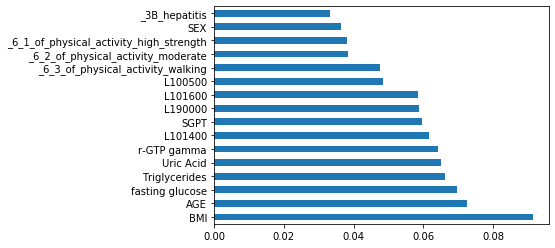

Index(['BMI', 'AGE', 'fasting glucose', 'Triglycerides', 'Uric Acid',
       'r-GTP gamma', 'L101400', 'SGPT', 'L190000', 'L101600', 'L100500',
       '_6_3_of_physical_activity_walking',
       '_6_2_of_physical_activity_moderate',
       '_6_1_of_physical_activity_high_strength', 'SEX', '_3B_hepatitis',
       'Drinking_5_1_days'],
      dtype='object')


In [103]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(x, y)

print(
    model.feature_importances_
)  # use inbuilt class feature_importances of tree based classifiers

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(17).index)

3.2 SelectKBest method
=========

In [132]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]  # naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:16]))

['BMI', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'r-GTP gamma', 'AGE', 'L101600', 'L100500', 'SGPT', 'L101400', 'L190000', 'SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', '_6_1_of_physical_activity_high_strength']


3.3 variance inflation factor 
=============

In [95]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance


def vifcal(inputdata, depcol):
    vifL5 = []
    import statsmodels.formula.api as sm

    xvars = inputdata.drop([depcol], axis=1)
    xvarnames = xvars.columns
    for i in range(0, xvarnames.shape[0]):
        _y = xvars[xvarnames[i]]
        _x = xvars[xvarnames.drop(xvarnames[i])]
        rsq = sm.ols(formula="_y~_x", data=xvars).fit().rsquared
        vif = round(1 / (1 - rsq), 2)
        print(i, ", ", xvarnames[i], " VIF = ", vif)
        if vif < 5:
            vifL5.append(xvarnames[i])
    return vifL5

In [97]:
# the new columns are selcted from section 3.2
# newcols = vifcal(mydata[['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX',
#                          'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100',
#                          'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31','CLASS']],'CLASS')

newcols = vifcal(
    mydata[
        [
        'BMI', 'Hemoglobin', 'RBC', 'HCT', 'Uric Acid', 'fasting glucose', 'Triglycerides', 'Cardiac risk factor', 
    'r-GTP gamma', 'AGE', 'L101600', 'total cholesterol', 'L100500', 'HDL-Cholesterol', 
    'SGPT', 'L101400', 'L190000', 'L190800',
    'SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_38_C', 
    '_6_1_of_physical_activity_high_strength', '_2_family_history_hypertension', '_6_2_of_physical_activity_moderate', 
    '_2_family_history_stroke', '_6_3_of_physical_activity_walking', '_3B_hepatitis', 'FIELD_28', 
    '_1_medication_heart_disease',
            "CLASS",
        ]
    ],
    "CLASS",
)
print(newcols, len(newcols))

# we need to exclude features with vif value >5
# L190400  ,L103300,L190500,L190300,L102900,L103100

0 ,  BMI  VIF =  1.55
1 ,  Hemoglobin  VIF =  612.76
2 ,  RBC  VIF =  5.69
3 ,  HCT  VIF =  469.27
4 ,  Uric Acid  VIF =  1.98
5 ,  fasting glucose  VIF =  1.29
6 ,  Triglycerides  VIF =  2.04
7 ,  Cardiac risk factor  VIF =  13.11
8 ,  r-GTP gamma  VIF =  1.56
9 ,  AGE  VIF =  1.3
10 ,  L101600  VIF =  1.23
11 ,  total cholesterol  VIF =  5.55
12 ,  L100500  VIF =  1.75
13 ,  HDL-Cholesterol  VIF =  8.42
14 ,  SGPT  VIF =  1.37
15 ,  L101400  VIF =  1.27
16 ,  L190000  VIF =  1.21
17 ,  L190800  VIF =  43.59
18 ,  SEX  VIF =  3.81
19 ,  _4_1_Smoking  VIF =  1.65
20 ,  Drinking_5_1_days  VIF =  4.15
21 ,  FIELD_38_C  VIF =  3.97
22 ,  _6_1_of_physical_activity_high_strength  VIF =  1.59
23 ,  _2_family_history_hypertension  VIF =  1.04
24 ,  _6_2_of_physical_activity_moderate  VIF =  1.7
25 ,  _2_family_history_stroke  VIF =  1.04
26 ,  _6_3_of_physical_activity_walking  VIF =  1.15
27 ,  _3B_hepatitis  VIF =  1.01
28 ,  FIELD_28  VIF =  1.02
29 ,  _1_medication_heart_disease  VIF =  1

3.4 Final Selected Features
======

In [203]:
# based on the out put of section of 3.2 and 3.3 the following features are selected


finalFeatures = [
    'BMI', 'r-GTP gamma', 'fasting glucose', 'Triglycerides', 'AGE', 'SGPT',
       'SEX', 'L101400', 'Uric Acid', 'L101600', 'L100500',
       '_6_1_of_physical_activity_high_strength', '_4_1_Smoking',
       'FIELD_38_C',
    'CLASS'
]



# finalFeatures=['HBA1C', 'Triglycerides', 'BMI',  'r-GTP gamma', 'SEX', 'AGE', 'Uric Acid',
#                '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength', 'Family_history','CLASS']

Classifier Model Test Based on the features 
========

In [204]:
randomseed = 7
mydata = data[finalFeatures].copy().dropna()
print(mydata.shape)
mydata.head()

(42416, 15)


,BMI,r-GTP gamma,fasting glucose,Triglycerides,AGE,SGPT,SEX,L101400,Uric Acid,L101600,L100500,_6_1_of_physical_activity_high_strength,_4_1_Smoking,FIELD_38_C,CLASS
3,24.3,39.0,105.0,130.0,49.0,15.0,0.0,288.0,2.0,53.0,1.0,3.0,2.0,1.0,2
4,23.7,24.0,118.0,92.0,50.0,12.0,0.0,264.0,2.8,49.0,1.0,2.0,2.0,1.0,2
50,21.7,12.0,95.0,64.0,46.0,13.0,1.0,218.0,2.5,24.0,0.8,3.0,1.0,1.0,2
82,26.4,40.0,98.0,187.0,48.0,19.0,0.0,418.0,8.4,72.0,1.4,1.0,1.0,1.0,2
83,26.3,41.0,104.0,99.0,49.0,19.0,0.0,374.0,9.2,70.0,1.3,1.0,3.0,1.0,2


In [205]:
class2 = mydata[mydata.CLASS == 2]
class1 = mydata[mydata.CLASS == 1]
class0 = mydata[mydata.CLASS == 0]

print(class2.shape[0], class1.shape[0], class0.shape[0])

14170 14015 14231


In [206]:
class2_test = class2.sample(1000, random_state=randomseed)
class1_test = class1.sample(1000, random_state=randomseed)
class0_test = class0.sample(1000, random_state=randomseed)
test = pd.concat([class2_test, class1_test, class0_test])
test=shuffle(test)

class2_train = class2.drop(class2_test.index)

class1_train = class1.drop(class1_test.index) #.sample( class2_train.shape[0], random_state=randomseed)

class0_train = class0.drop(class0_test.index) #.sample( class2_train.shape[0], random_state=randomseed)
train = pd.concat([class2_train, class1_train, class0_train])
train=shuffle(train)

In [207]:
# # generate synthetic dataset to overcome class imbalance
# from collections import Counter
# from numpy.random import RandomState
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTENC

# sm = SMOTENC(random_state=42, categorical_features=[5, 6, 7, 8])
# X_res, y_res = sm.fit_resample(train.iloc[:, :-1], train.iloc[:, -1])
# print("Resampled dataset samples per class {}".format(Counter(y_res)))

# train = pd.DataFrame(X_res, columns=list(train.columns[:-1]))
# train["CLASS"] = y_res

In [208]:
# from sklearn.preprocessing import RobustScaler

# transformer = RobustScaler()
# transformer.fit(train.iloc[:, :-1])
# train.iloc[:, :-1] = transformer.transform(train.iloc[:, :-1])
# test.iloc[:, :-1] = transformer.transform(test.iloc[:, :-1])

In [209]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=randomseed, n_estimators=100, max_depth=10)
rf.fit(train.iloc[:, :-1], train.iloc[:, -1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.568


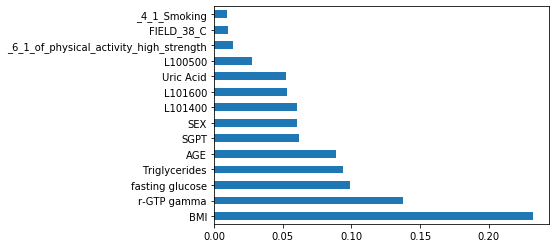

Index(['BMI', 'r-GTP gamma', 'fasting glucose', 'Triglycerides', 'AGE', 'SGPT',
       'SEX', 'L101400', 'L101600', 'Uric Acid', 'L100500',
       '_6_1_of_physical_activity_high_strength', 'FIELD_38_C',
       '_4_1_Smoking'],
      dtype='object')
1.0


In [210]:
ypred = rf.predict(test.iloc[:, :-1])

score = rf.score(test.iloc[:, :-1], test.iloc[:, -1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

print(np.sum(feat_importances.nlargest(16)))

In [211]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test.iloc[:, -1], ypred)

array([[644, 225, 131],
       [240, 369, 391],
       [110, 199, 691]], dtype=int64)

In [212]:
print(
    "Accuracy on training set: {:.3f}".format(
        rf.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
ypred = rf.predict(test.iloc[:, :-1])

confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], ypred))
confmatrx.head()

Accuracy on training set: 0.656
Accuracy on test set: 0.568


,0,1,2
0,644,225,131
1,240,369,391
2,110,199,691


In [213]:
from sklearn.metrics import classification_report

print(classification_report(test.iloc[:, -1], ypred))

              precision    recall  f1-score   support

           0       0.65      0.64      0.65      1000
           1       0.47      0.37      0.41      1000
           2       0.57      0.69      0.62      1000

    accuracy                           0.57      3000
   macro avg       0.56      0.57      0.56      3000
weighted avg       0.56      0.57      0.56      3000



In [231]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=randomseed, num_class=3)

xgb_model.fit(train.iloc[:, :-1], train.iloc[:, -1])

y_pred = xgb_model.predict((test.iloc[:, :-1]))

print(
    "Accuracy on training set: {:.3f}".format(
        xgb_model.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(xgb_model.score(test.iloc[:, :-1], test.iloc[:, -1]))
)
confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
confmatrx.head()

Accuracy on training set: 0.574
Accuracy on test set: 0.564


,0,1,2
0,658,206,136
1,267,344,389
2,101,209,690


In [217]:
print(classification_report(test.iloc[:, -1], y_pred))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65      1000
           1       0.45      0.34      0.39      1000
           2       0.57      0.69      0.62      1000

    accuracy                           0.56      3000
   macro avg       0.55      0.56      0.55      3000
weighted avg       0.55      0.56      0.55      3000



In [232]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(train.iloc[:, :-1], train.iloc[:, -1])


Accuracy on training set: 1.000
Accuracy on test set: 0.401


In [235]:
ypred=clf.predict((test.iloc[:, :-1]))

print(
    "Accuracy on training set: {:.3f}".format(
        clf.score(train.iloc[:, :-1], train.iloc[:, -1])
    )
)
print(
    "Accuracy on test set: {:.3f}".format(clf.score(test.iloc[:, :-1], test.iloc[:, -1]))
)

confmatrx = pd.DataFrame(confusion_matrix(test.iloc[:, -1], y_pred))
confmatrx.head()

Accuracy on training set: 1.000
Accuracy on test set: 0.401


,0,1,2
0,658,206,136
1,267,344,389
2,101,209,690


In [237]:
print(classification_report(test.iloc[:, -1], ypred))

              precision    recall  f1-score   support

           0       0.70      0.22      0.34      1000
           1       0.29      0.02      0.03      1000
           2       0.37      0.96      0.53      1000

    accuracy                           0.40      3000
   macro avg       0.45      0.40      0.30      3000
weighted avg       0.45      0.40      0.30      3000



===============================
==========

In [238]:
from scipy.stats.stats import pearsonr  
temp=train.copy()

con=[]
for i in range(temp.shape[0]):
    con.append ([pearsonr(temp.iloc[0,:-1].values,
                    temp.iloc[i,:-1].values)[0],i,temp.iloc[i,-1],temp.index[i]])

In [239]:
con=pd.DataFrame(con,columns=['val','index','class','ai'])
con=con.sort_values(by='val', ascending=False)

In [240]:
con.head()

,val,index,class,ai
0,1.000000,0,2,29009
7641,0.999871,7641,2,151515
32438,0.999775,32438,0,15903
36512,0.999579,36512,1,135209
27459,0.999525,27459,2,158644


In [249]:
train[train.index.isin( list(con.head(15).ai) )]

,BMI,r-GTP gamma,fasting glucose,Triglycerides,AGE,SGPT,SEX,L101400,Uric Acid,L101600,L100500,_6_1_of_physical_activity_high_strength,_4_1_Smoking,FIELD_38_C,CLASS
29009,17.1,25.0,100.0,53.0,54.0,20.0,0.0,320.0,4.9,66.0,0.9,1.0,1.0,0.0,2
38165,21.7,18.0,100.0,53.0,53.0,21.0,0.0,304.0,3.2,64.0,1.0,0.0,2.0,0.0,1
151515,22.0,28.0,106.0,57.0,60.0,25.0,0.0,343.0,5.4,71.0,1.0,4.0,1.0,1.0,2
153821,24.5,28.0,100.0,60.0,54.0,22.0,0.0,344.0,5.4,73.0,1.3,0.0,2.0,1.0,2
128929,24.5,25.0,101.0,57.0,55.0,24.0,1.0,316.0,3.7,64.0,0.8,0.0,1.0,0.0,1
499177,16.4,20.0,89.0,45.0,45.0,16.0,1.0,285.0,3.8,50.0,0.8,0.0,1.0,1.0,0
1961,18.6,20.0,86.0,52.0,48.0,16.0,0.0,287.0,6.7,55.0,1.5,0.0,3.0,1.0,0
27565,21.8,27.0,91.0,45.0,51.0,20.0,0.0,305.0,5.0,64.0,1.1,0.0,2.0,1.0,1
158644,20.1,18.0,97.0,54.0,51.0,18.0,1.0,310.0,3.4,68.0,0.8,0.0,1.0,1.0,2
187246,17.9,23.0,88.0,48.0,45.0,19.0,1.0,296.0,4.9,66.0,0.7,1.0,1.0,1.0,0


In [250]:
temp.tail(10)

,BMI,r-GTP gamma,fasting glucose,Triglycerides,AGE,SGPT,SEX,L101400,Uric Acid,L101600,L100500,_6_1_of_physical_activity_high_strength,_4_1_Smoking,FIELD_38_C,CLASS
306355,23.4,17.0,100.0,76.0,50.0,17.0,0.0,296.0,4.7,44.0,0.9,0.0,1.0,1.0,2
357561,21.7,32.0,89.0,73.0,49.0,21.0,0.0,281.0,3.8,60.0,1.0,0.0,2.0,1.0,1
162703,28.4,60.0,110.0,154.0,35.0,36.0,0.0,335.0,6.1,70.0,1.1,2.0,2.0,1.0,2
43322,22.8,18.0,98.0,75.0,52.0,17.0,1.0,276.0,3.8,66.0,0.6,0.0,1.0,0.0,1
452779,26.0,21.0,92.0,86.0,41.0,13.0,0.0,325.0,7.2,51.0,1.0,0.0,1.0,1.0,1
17300,20.7,39.0,100.0,92.0,50.0,16.0,0.0,318.0,6.9,41.0,1.1,1.0,3.0,2.0,0
187027,23.5,15.0,98.0,62.0,34.0,13.0,0.0,147.0,4.4,43.0,0.9,1.0,2.0,2.0,0
514558,26.5,36.0,105.0,133.0,48.0,26.0,0.0,172.0,5.8,71.0,1.0,1.0,3.0,1.0,2
155179,22.8,67.0,100.0,67.0,34.0,35.0,0.0,304.0,6.7,73.0,1.2,1.0,2.0,1.0,1
307384,23.1,25.0,95.0,100.0,32.0,23.0,1.0,340.0,5.1,59.0,0.8,3.0,1.0,0.0,1


In [251]:
list(con.tail(10).ai)

[212154, 408943, 275392, 18890, 4522, 430730, 6064, 355498, 374327, 272864]

In [252]:
con.tail(10)

,val,index,class,ai
66,0.161726,66,2,212154
26945,0.160889,26945,2,408943
24293,0.157503,24293,2,275392
5683,0.152044,5683,2,18890
5858,0.148133,5858,2,4522
31501,0.141221,31501,2,430730
11736,0.139233,11736,2,6064
36693,0.136447,36693,1,355498
28577,0.090831,28577,0,374327
30090,0.086061,30090,2,272864
